In [1]:
# installing required libraries
! pip install networkx
! pip install plotly
! pip install colorlover
! pip install NRCLex
! pip install tweet-preprocessor

In [2]:
#importing required functions

import pandas as pd
import numpy as np
from collections import Counter
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.graph_objs import *
import plotly.graph_objects as go
init_notebook_mode(connected=True)

import colorlover as cl
from IPython.display import HTML
import preprocessor as p

import re
import nltk
from nrclex import NRCLex
nltk.download('punkt')
from nltk.stem import *
nltk.download("stopwords")
from nltk.corpus import stopwords


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# configuring plotly browser state to represent networkgraph
def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',
            },
          });
        </script>
        '''))

In [4]:
# defining dataframe from csv zip file
df = pd.read_csv("tweets2009-06-0115.csv.zip", sep='\t', compression='zip')

In [5]:
print("Num of rows:", df.shape[0])

Num of rows: 3437690


In [6]:
df.head()

date        user          tweet
0  2009-06-01 21:43:59  burtonator  No Post Title
1  2009-06-01 21:47:23  burtonator  No Post Title
2  2009-06-02 01:15:44  burtonator  No Post Title
3  2009-06-02 05:17:52  burtonator  No Post Title
4  2009-06-02 23:58:25  burtonator  No Post Title

In [7]:
# print all hashtags with its counts
allTweets = df["tweet"].str.cat(sep=' ')
tweetWords = [word.strip(""" ,.:'\";""").lower() for word in allTweets.split()]
hashTags = [word for word in tweetWords if word.startswith("#")]
hashTagsCounter = Counter(hashTags)

In [8]:
hashTagsCounter.most_common(150)

[('#iranelection', 26853),
 ('#followfriday', 16400),
 ('#jobs', 13322),
 ('#iremember', 11057),
 ('#spymaster', 10587),
 ('#ff', 10446),
 ('#squarespace', 9198),
 ('#tcot', 7691),
 ('#fb', 6107),
 ('#cnnfail', 4451),
 ('#11thcommandment', 3429),
 ('#jtv', 3317),
 ('#140mafia', 3144),
 ('#iran', 2935),
 ('#', 2895),
 ('#news', 2837),
 ('#quote', 2750),
 ('#vampirebite', 2634),
 ('#1', 2587),
 ('#bsb', 2433),
 ('#tweetmyjobs', 2086),
 ('#iphone', 1697),
 ('#lastfm', 1599),
 ('#mp2', 1589),
 ('#niley', 1528),
 ('#music', 1489),
 ('#p2', 1439),
 ('#follow', 1390),
 ('#pawpawty', 1305),
 ('#hhrs', 1256),
 ('#fail', 1246),
 ('#twitter', 1216),
 ('#tlot', 1214),
 ('#facebook', 1177),
 ('#sgp', 1151),
 ('#mashchat', 1143),
 ('#tinychat', 1111),
 ('#2', 1107),
 ('#digg', 1102),
 ('#gop', 1009),
 ('#phish', 1001),
 ('#mlb', 962),
 ('#travel', 932),
 ('#bonnaroo', 887),
 ('#twitpocalypse', 879),
 ('#iranelections', 857),
 ('#rt', 856),
 ('#zensursula', 811),
 ('#jamlegend', 790),
 ('#quotes', 75

# Q(1): Choose a hash-tag:

## I am selecting #twitter for analysis.

In [9]:
# make a new dataframe just with my hashtag
tweetTag = df[df["tweet"].str.lower().str.contains("#twitter", na=False)].copy()

In [10]:
tweetTag.shape

(2950, 3)

# Q(2): Build a mention graph:

In [11]:
def addMentionedColumn(df):
    
    def mentionsList(txt):
        allWords = [word.strip(""" ,.:'\";""").lower() for word in txt.split()]
        allNames = [word.strip("@") for word in allWords if word.startswith("@")]
        uniqueNames = list(set(allNames))
        return allNames
    
    df["mentioned"] = df["tweet"].apply(mentionsList)

In [12]:
addMentionedColumn(tweetTag) # adding column with mentions in the tweets

In [13]:
tweetTag.head(10)

date  ...                                          mentioned
2632   2009-06-11 17:01:45  ...                                                 []
4190   2009-06-11 17:05:47  ...                                      [beckelhimer]
7625   2009-06-11 17:10:25  ...                                                 []
8347   2009-06-11 17:10:58  ...                                                 []
9401   2009-06-11 17:11:48  ...                                           [devan_]
9751   2009-06-11 17:12:19  ...                                                 []
9848   2009-06-11 17:12:31  ...  [jordi_ruizr, luismiguelromer, alexhereza, hec...
10558  2009-06-11 17:13:11  ...                                   [ruth_z, ruth_z]
11633  2009-06-11 17:14:00  ...                                                 []
12589  2009-06-11 17:15:21  ...                                         [clippinx]

[10 rows x 4 columns]

In [14]:
len(tweetTag.mentioned.value_counts()) # these number of mentions are there in all tweets

932

In [15]:
# for all the tweets with your hashtag, build the mention graph
def mentionGraph(df):
    g = nx.Graph()
    
    for (index, date, user, tweet, mentionedUsers) in df.itertuples():
        for mentionedUser in mentionedUsers:
            if (user in g) and (mentionedUser in g[user]):
                g[user][mentionedUser]["numberMentions"] += 1
            else:
                g.add_edge(user, mentionedUser, numberMentions=1)
    
    return g

In [16]:
tweetGraph = mentionGraph(tweetTag) #building mention graph

# Q2(a): How many nodes and how many edges are in your mention graph?

In [17]:
#number of nodes and edges in the mention graph
print("# nodes:", len(tweetGraph.nodes()))
print("# edges:", len(tweetGraph.edges()))

# nodes: 2095
# edges: 1914


- There are 2095 nodes or users and 1914 edges or connections.

In [18]:
tweetGraph["ruth_z"]

AtlasView({'champagnemanoir': {'numberMentions': 2}, 'drsharonmelnick': {'numberMentions': 1}, 'vipvirtualsols': {'numberMentions': 1}, 'judi_po': {'numberMentions': 1}, 'roy_zori': {'numberMentions': 1}, 'jimsuccessful': {'numberMentions': 1}, 'maya_bluebird': {'numberMentions': 2}, 'lil_shalom': {'numberMentions': 3}, 'thomas_fischer': {'numberMentions': 1}, 'sweetlilmzmia': {'numberMentions': 1}})

# Q2(b): Build a histogram of the graph nodes’ degree.

Text(0.5, 1.0, 'Degree distribution of the graph')

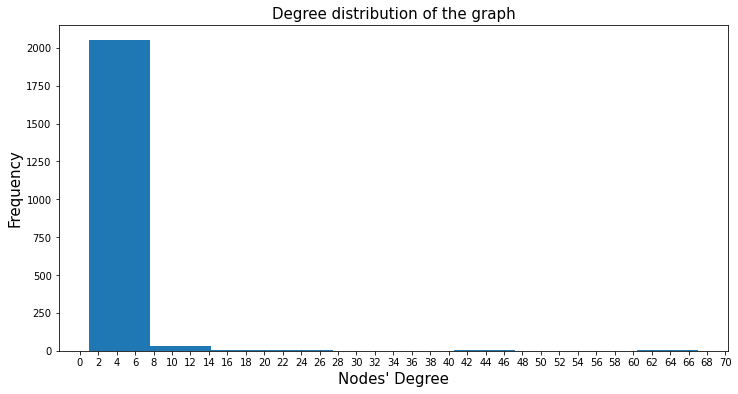

In [19]:
plt.figure(figsize=(12,6))
plt.hist(dict(tweetGraph.degree).values())
plt.xlabel("Nodes' Degree", size =15)
plt.ylabel("Frequency", size =15)
plt.xticks(range(0,71,2))
plt.title("Degree distribution of the graph", size =15)

- It is observed that most of the nodes' degree lies in the range of 1 to 7. Some of the nodes have degrees between 8 to 27 and 41 to 46 and 61 to 67. This shows that almost 2000 nodes or users have connections with other 1 to 7 users whereas very few have more than 8 connections.

# Q2(c): Build a log-log scatterplot with the node degree (x-axis) and fraction of nodes with that degree (y-axis).

In [20]:
degrees = []
for node, degree in tweetGraph.degree:
  degrees.append(degree)

df_degree = pd.DataFrame(pd.Series(degrees).value_counts(), columns = ["node_count"])
fraction = []
for i in df_degree["node_count"]:
  fraction_count = i/len(tweetGraph.nodes())
  fraction.append(fraction_count)

df_degree["fraction_of_nodes"] = fraction

df_degree

node_count  fraction_of_nodes
1         1448           0.691169
2          366           0.174702
3          130           0.062053
4           57           0.027208
5           26           0.012411
6           14           0.006683
10          10           0.004773
7            9           0.004296
8            8           0.003819
9            4           0.001909
12           3           0.001432
19           2           0.000955
15           2           0.000955
13           2           0.000955
11           2           0.000955
14           2           0.000955
47           1           0.000477
16           1           0.000477
42           1           0.000477
18           1           0.000477
26           1           0.000477
32           1           0.000477
39           1           0.000477
63           1           0.000477
23           1           0.000477
67           1           0.000477

Text(0.5, 1.0, 'log-log scatter plot of node degree and fraction of nodes')

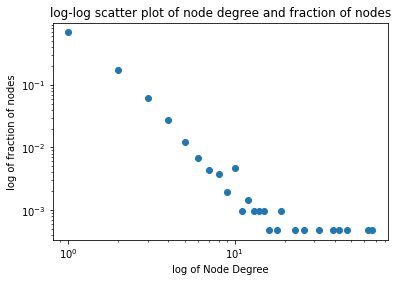

In [21]:
plt.scatter(df_degree.index, df_degree["fraction_of_nodes"])
plt.loglog(basex=10,basey=10)
plt.xlabel("log of Node Degree")
plt.ylabel("log of fraction of nodes")
plt.title("log-log scatter plot of node degree and fraction of nodes")

- The above graph represents a power law trend between node degree and fraction of total nodes. It shows that as the degree of the node increases the number of nodes having high degree decreases. 

In [22]:
tweetGraph.edges(data=True)

EdgeDataView([('mizzlizzbeck', 'beckelhimer', {'numberMentions': 1}), ('rustysteelwool', 'devan_', {'numberMentions': 1}), ('sabria', 'jordi_ruizr', {'numberMentions': 1}), ('sabria', 'luismiguelromer', {'numberMentions': 1}), ('sabria', 'alexhereza', {'numberMentions': 1}), ('sabria', 'hector_san', {'numberMentions': 1}), ('sabria', 'peremarti', {'numberMentions': 1}), ('sabria', 'pedropporto', {'numberMentions': 1}), ('champagnemanoir', 'ruth_z', {'numberMentions': 2}), ('ruth_z', 'drsharonmelnick', {'numberMentions': 1}), ('ruth_z', 'vipvirtualsols', {'numberMentions': 1}), ('ruth_z', 'judi_po', {'numberMentions': 1}), ('ruth_z', 'roy_zori', {'numberMentions': 1}), ('ruth_z', 'jimsuccessful', {'numberMentions': 1}), ('ruth_z', 'maya_bluebird', {'numberMentions': 2}), ('ruth_z', 'lil_shalom', {'numberMentions': 3}), ('ruth_z', 'thomas_fischer', {'numberMentions': 1}), ('ruth_z', 'sweetlilmzmia', {'numberMentions': 1}), ('wahlbuzz', 'clippinx', {'numberMentions': 1}), ('wahlbuzz', 'te

# Q2(d): For the highest-weighted edge, list the tweets (up to 25) for that edge.

In [23]:
df_mentions = pd.DataFrame(columns= ["handler","mention_name","number_mentions"])

handlers = []
mentions = []
numbers_m = []

for handler, mention , number_mentions in tweetGraph.edges(data=True):
  handlers.append(handler)
  mentions.append(mention)
  numbers_m.append(number_mentions["numberMentions"])

df_mentions["handler"] = handlers
df_mentions["mention_name"] = mentions
df_mentions["number_mentions"] = numbers_m

In [24]:
df_mentions.sort_values(by = "number_mentions",  ascending=False).head()

handler  mention_name  number_mentions
1579   thesnarkyone    justusleeg                9
1285   recentsearch  recentsearch                9
1389     mileycyrus      vonnieee                9
1437    tcoldenburg         ths01                7
598   lesleylambert    khopkinson                5

In [25]:
top_edge = tweetTag[tweetTag["user"]=="thesnarkyone"] # showing tweets with highest mentions

In [26]:
top_edge.tweet.values

array(['RT @JustUsLeeg: Web Discovery: Torrent Twitter. http://tinyurl.com/l8lmbv #twitter #web #torrents',
       'RT @JustUsLeeg: Web Discovery: Torrent Twitter. http://tinyurl.com/l8lmbv #twitter #web #torrents',
       'RT @JustUsLeeg: Web Discovery: Torrent Twitter. http://tinyurl.com/l8lmbv #twitter #web #torrents',
       'RT @JustUsLeeg: What is the Twitpocalypse? http://tinyurl.com/mandzs #twitter #twitpocalypse #web #Y2K',
       'RT @JustUsLeeg: What is the Twitpocalypse? http://tinyurl.com/mandzs #twitter #twitpocalypse #web #Y2K',
       'RT @JustUsLeeg: What is the Twitpocalypse? http://tinyurl.com/mandzs #twitter #twitpocalypse #web #Y2K',
       'RT @JustUsLeeg: What is the Twitpocalypse? http://tinyurl.com/mandzs #twitter #twitpocalypse #web #Y2K',
       'RT @JustUsLeeg: What is the Twitpocalypse? http://tinyurl.com/mandzs #twitter #twitpocalypse #web #Y2K',
       'RT @JustUsLeeg: What is the Twitpocalypse? http://tinyurl.com/mandzs #twitter #twitpocalypse #web #Y2K'

- We can see that all the above tweets are retweets and all are about sharing some sort of web links. The first three links are of torrents and the other 6 links are about the "Twitpocalypse" bug that happened in 2009. Some of the third party applications using Twitter API were crashed due to this bug and this bug was the same as the Y2K bug. That's why the Y2K hashtag can be seen in the retweet. 
- The tweets mentioned the question "What is the Twitpocalypse?", 2009 people were not aware of this bug and I believe to spread some knowledge about the bug, the user had retweeted the tweets and that's why this edge has the highest weight.

In [27]:
top_edge_ = tweetTag[tweetTag["user"]=="recentsearch"]

In [28]:
top_edge_.tweet.values

array(['[new] Searched Twitter for #twitteranalyzer: http://tinyurl.com/mzoard http://url4.eu/2Qf',
       '[new] RT @recentsearch [new] Searched Twitter for #twitteranalyzer: http://tinyurl.com/mzoard http://url4.eu/2Qf http://url4.eu/43Z',
       '[new] RT @hoghannah Searched Twitter for #twitteranalyzer: http://tinyurl.com/mzoard http://url4.eu/43b',
       '[new] RT @recentsearch [new] Searched Twitter for #twitteranalyzer: http://tinyurl.com/mzoard http://url4.eu/43b http://url4.eu/4JE',
       '[new] RT @recentsearch [new] Searched Twitter for #twitteranalyzer: http://tinyurl.com/mzoard http://url4.eu/2Qf http://url4.eu/4Yv',
       '[new] RT @recentsearch [new] [new] Searched Twitter for #twitteranalyzer: http://tinyurl.com/mzoard http://url4.eu/2Qf ht http://url4.eu/4hG',
       '[new] RT @recentsearch [new] [new] [new] Searched Twitter for #twitteranalyzer: http://tinyurl.com/mzoard http://url4.eu/ http://url4.eu/4wY',
       '[new] RT @recentsearch [new] [new] Searched Twitte

- For the second user with the highest edge weight, we can see that all the tweets are retweets and it mentioned something related to twitteranalyzer and had some URL links.

# Q2(e): Provide a visualization of the mention graph in which the edges visually (e.g., color, weight, etc.) reflects its weight (i.e., the number of mentions)

In [29]:
import random
def addRandomPositions(graph):
    posDict = dict((node,(random.gauss(0,10),random.gauss(0,10))) for node in graph.nodes())
    nx.set_node_attributes(graph, name="pos", values=posDict)

In [30]:
addRandomPositions(tweetGraph)

In [31]:
def plotNetworkSize(graph):
    scatters=[]

    # make all the edges
    for (node1, node2) in graph.edges():
        x0, y0 = graph.nodes[node1]['pos']
        x1, y1 = graph.nodes[node2]['pos']
        edgeWidth = graph[node1][node2]['numberMentions']
        s = Scatter(
                x=[x0, x1],
                y=[y0, y1],
                hoverinfo='none',
                mode='lines', 
                line=scatter.Line(width=edgeWidth ,color='#888'))
        scatters.append(s)


    # make all the nodes
    for node in graph.nodes():
        xPos, yPos = graph.nodes[node]['pos']
        s = Scatter(
                x=[xPos], 
                y=[yPos], 
                hoverinfo='none',
                mode='markers', 
                marker=dict(
                    color="#888", 
                    size=nx.degree(graph,node)*2,         
                    line=dict(width=2)))
        scatters.append(s)
    
    layout = Layout(showlegend=False)
    fig = Figure(data=scatters, layout=layout)
    iplot(fig, show_link=False)

In [32]:
configure_plotly_browser_state()
plotNetworkSize(tweetGraph)

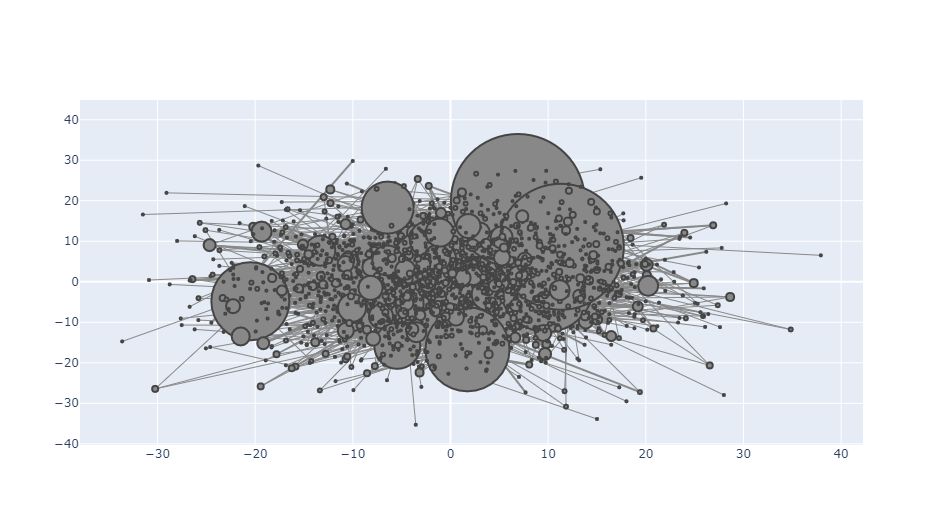


- The above graph represents a mention graph without color and layout. The width of the edges represents the number of mentions by the user. Let's use color to differentiate the closeness centrality of the nodes.

In [33]:
# map purd color scale to 300 cells
purd = cl.scales['9']['seq']['YlOrRd']
purd300 = cl.interp(purd, 300)
HTML(cl.to_html(purd300))

In [34]:
def plotNetworkSizeColor(graph):
    closenessCentr = nx.closeness_centrality(tweetGraph)
    maxCentr = max(closenessCentr.values())
    minCentr = min(closenessCentr.values())
    
    scatters=[]

    for (node1, node2) in graph.edges():
        x0, y0 = graph.nodes[node1]['pos']
        x1, y1 = graph.nodes[node2]['pos']
        edgeWidth = graph[node1][node2]['numberMentions']
        s = Scatter(
                x=[x0, x1],
                y=[y0, y1],
                hoverinfo='none',
                mode='lines', 
                line=scatter.Line(width=edgeWidth ,color='#888'))
        scatters.append(s)



    for node in graph.nodes():
        nodeCentr = closenessCentr[node]
        nodeColor = int(299*(nodeCentr-minCentr)/(maxCentr-minCentr))
        xPos, yPos = graph.nodes[node]['pos']
        s = Scatter(
                x=[xPos], 
                y=[yPos], 
                text="User: %s <br> Closeness: %.3f" % (node, nodeCentr),
                hoverinfo='text',
                mode='markers', 
                marker=dict(
                    color=purd300[nodeColor], 
                    size=nx.degree(graph,node)*2,         
                    line=dict(width=2)))
        scatters.append(s)
    
    layout = Layout(showlegend=False)
    fig = Figure(data=scatters, layout=layout)
    iplot(fig, show_link=False)

In [35]:
configure_plotly_browser_state()
plotNetworkSizeColor(tweetGraph)

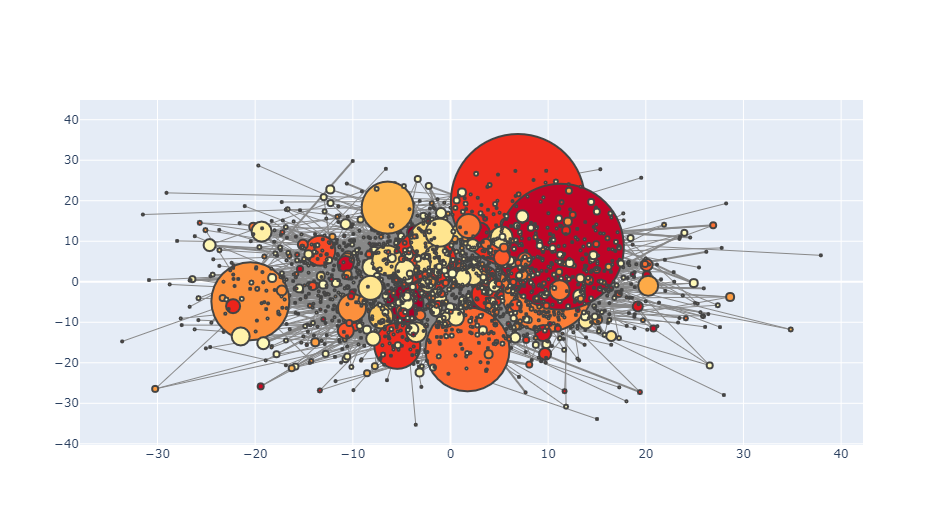

- The above mention graph with color represents the closeness centrality of the nodes. The dark red color nodes have high centrality whereas light color nodes have low centrality. The closeness centrality of the nodes represents how close the users are in a network. This shows which node/user has the shortest distance to the other node/user. Let's represent the graph in the spring layout to have a better representation. 

## Mention graph with a spring layout

In [36]:
def applyLayout(graph, layoutFunc):
    posDict = layoutFunc(graph) 
    nx.set_node_attributes(graph, name="pos", values=posDict)

In [37]:
tweetGraphSpring = tweetGraph.copy()
applyLayout(tweetGraphSpring, nx.spring_layout)
configure_plotly_browser_state()
plotNetworkSizeColor(tweetGraphSpring)

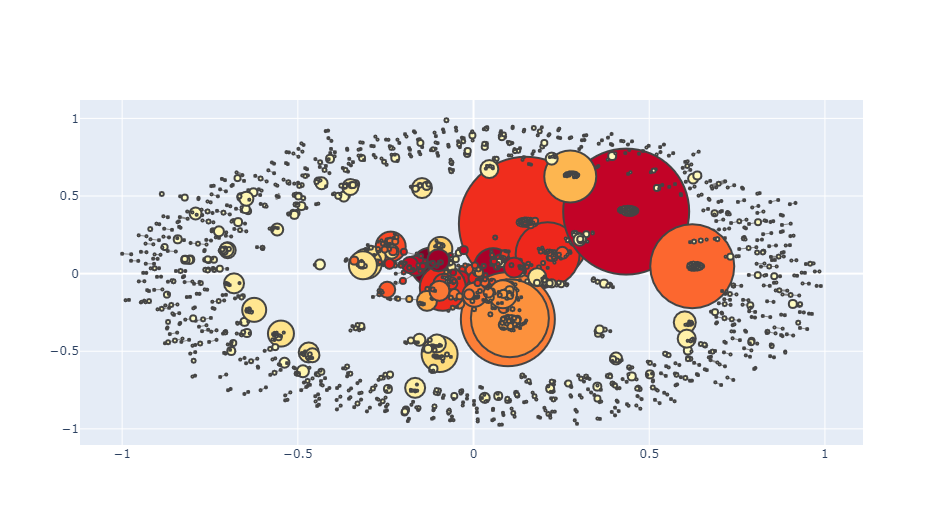

- I have used a spring layout for better visualization of the mention graph. 
- The width of the edge increases as the mentions by the user increase. The color of the node represents the closeness centrality of the node.
- The spring layout is based on the Fruchterman-Reingold force-directed algorithm. 
- The algorithm simulates a force-directed representation of the network treating edges as springs holding nodes close while treating nodes as repelling objects, sometimes called an anti-gravity force. Simulation continues until the positions are close to an equilibrium.

Source: https://networkx.org/documentation/stable//reference/generated/networkx.drawing.layout.spring_layout.html

# Q(3): Content Analysis

- I have used a twitter processor to clean tweets for content analysis. The processor cleans URLs, hashtags, mentions, reserved words, emojis, and smileys.
Source: https://pypi.org/project/tweet-preprocessor/

In [38]:
tweetTag["preprocess_tweets"] = [p.clean(i) for i in tweetTag.tweet.values] #adding clean tweets column 
tweetTag.head()

date  ...                                  preprocess_tweets
2632  2009-06-11 17:01:45  ...       Apocalypse Status the end is comming soon...
4190  2009-06-11 17:05:47  ...             yes! Yay for trending retarded topics!
7625  2009-06-11 17:10:25  ...  want to know how many of your followers are ac...
8347  2009-06-11 17:10:58  ...  last bit of cracking on now (hopefully avoidin...
9401  2009-06-11 17:11:48  ...  no, owes it to its users. find a way to gain c...

[5 rows x 5 columns]

# Q3(a): Analyze the most frequent non-stopwords in all the tweets

In [39]:
def get_stop_words():
    stop = set(stopwords.words('english'))
    #Add possible Stop Words for Hotel Reviews
    # stop.add("http")
    # stop.add("www")
    # stop.add("com")
    stop.add("twitter") # adding twitter word into stopword as it is the main hashtag so it is obvious that it is going to be in one of the frequent words
    # stop.add("bit")

    
    return stop

def getTopKWords(df, kwords):

    stop = get_stop_words()
    counter = Counter()

    tweets = df['preprocess_tweets'].values

    for tweet in tweets:
            counter.update([word.lower() 
                            for word 
                            in re.findall(r'\w+', tweet)
                            if word.lower() not in stop and len(word) > 2 ])
    topk = counter.most_common(kwords)
    return topk


In [40]:
getTopKWords(tweetTag, 50)

[('user', 359),
 ('new', 285),
 ('friends', 261),
 ('pls', 217),
 ('tweet', 205),
 ('statistics', 202),
 ('check', 165),
 ('habits', 141),
 ('see', 134),
 ('used', 131),
 ('tweets', 130),
 ('great', 112),
 ('die', 105),
 ('via', 103),
 ('followers', 92),
 ('added', 91),
 ('get', 87),
 ('follow', 84),
 ('people', 81),
 ('search', 80),
 ('usage', 78),
 ('please', 76),
 ('letzten', 75),
 ('hat', 74),
 ('readers', 73),
 ('add', 73),
 ('daily', 72),
 ('tweeting', 70),
 ('know', 69),
 ('deinen', 68),
 ('erfasst', 68),
 ('thanks', 68),
 ('weekly', 63),
 ('monthly', 60),
 ('marketing', 58),
 ('api', 55),
 ('app', 55),
 ('active', 54),
 ('raise', 52),
 ('hourly', 52),
 ('find', 51),
 ('twitpocalypse', 51),
 ('petition', 50),
 ('directory', 50),
 ('many', 48),
 ('empty', 48),
 ('ppl', 48),
 ('words', 48),
 ('want', 47),
 ('good', 47)]

- In the top 50 most frequent words, we can see that words like the user, new, tweet, statistics, people, know, please and usage, etc. are the common words that do not convey any particular theme or conversation. 
- But there is a word like marketing that suggests that probably people were trying to market their products through Twitter, and words like app, api and twitpocalypse suggest that people were discussing twitpocalypse bug on Twitter. 

# Q3(b): In a visualization of the mention graph add hover information for the nodes which lists the 3 most common words for each user

In [41]:
# defining color for empty nodes

empty_node = cl.scales['9']['seq']['Greys'][6]
# empty_node_colour = cl.interp(empty_node, 300)
# HTML(cl.to_html(empty_node_colour))
empty_node

'rgb(82,82,82)'

In [42]:
# selecting top 3 words of the users

def userWiseTopWords(df, user):
  new_df = df[df["user"]==user]
  words = getTopKWords(new_df, 3)
  top3_words = [word[0] for word in words]
  return top3_words

In [43]:
def plotNetworkSizeColor_nodes_words(graph):
    closenessCentr = nx.closeness_centrality(tweetGraph)
    maxCentr = max(closenessCentr.values())
    minCentr = min(closenessCentr.values())
    
    scatters=[]

    for (node1, node2) in graph.edges():
        x0, y0 = graph.nodes[node1]['pos']
        x1, y1 = graph.nodes[node2]['pos']
        edgeWidth = graph[node1][node2]['numberMentions']
        s = Scatter(
                x=[x0, x1],
                y=[y0, y1],
                hoverinfo='none',
                mode='lines', 
                line=scatter.Line(width=edgeWidth ,color='#888'))
        scatters.append(s)



    for node in graph.nodes():
        nodeCentr = closenessCentr[node]
        nodeColor = int(299*(nodeCentr-minCentr)/(maxCentr-minCentr))

        xPos, yPos = graph.nodes[node]['pos']
        s = Scatter(
                x=[xPos], 
                y=[yPos], 
                text="User: %s <br> Closeness: %.3f <br> Top3_words: %s" % (node, nodeCentr, str(userWiseTopWords(tweetTag, user=node))),
                hoverinfo='text',
                mode='markers', 
                marker=dict(
                    color= empty_node if len(userWiseTopWords(tweetTag, user=node)) == 0 else purd300[nodeColor], 
                    size=nx.degree(graph,node)*2,         
                    line=dict(width=2)))
        scatters.append(s)
    
    layout = Layout(showlegend=False)
    fig = Figure(data=scatters, layout=layout)
    iplot(fig, show_link=False)

In [44]:
configure_plotly_browser_state()
plotNetworkSizeColor_nodes_words(tweetGraphSpring)

Output hidden; open in https://colab.research.google.com to view.

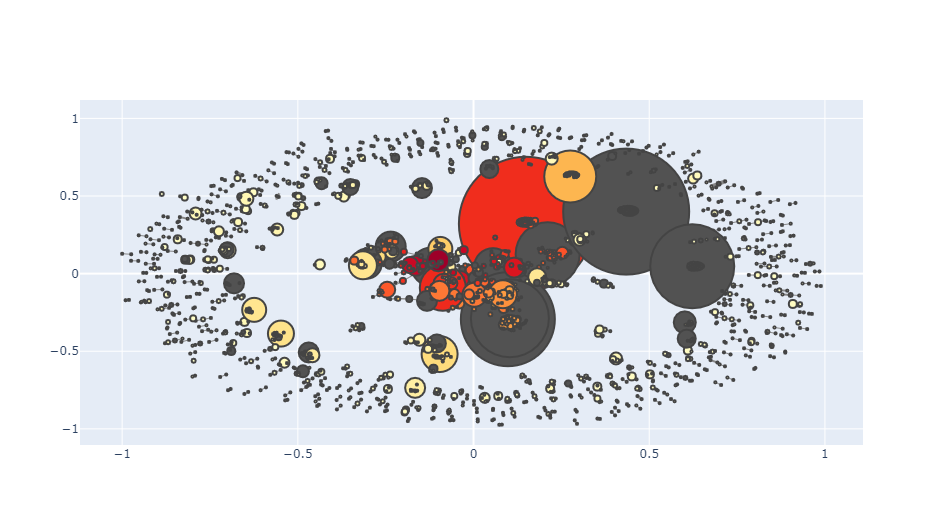

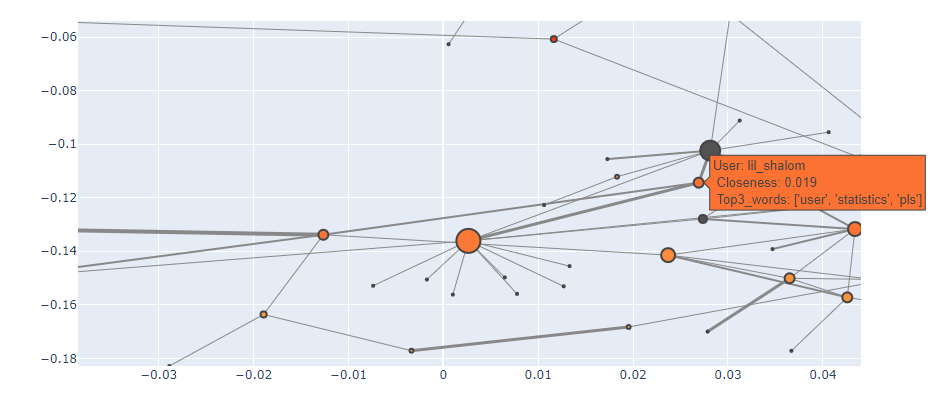

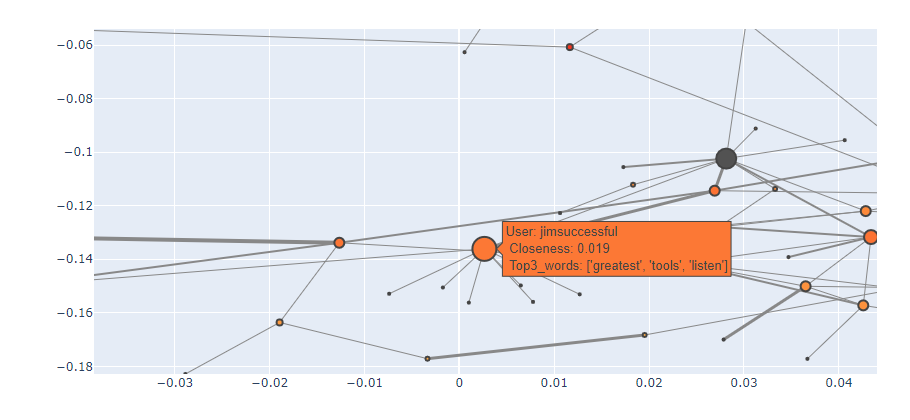

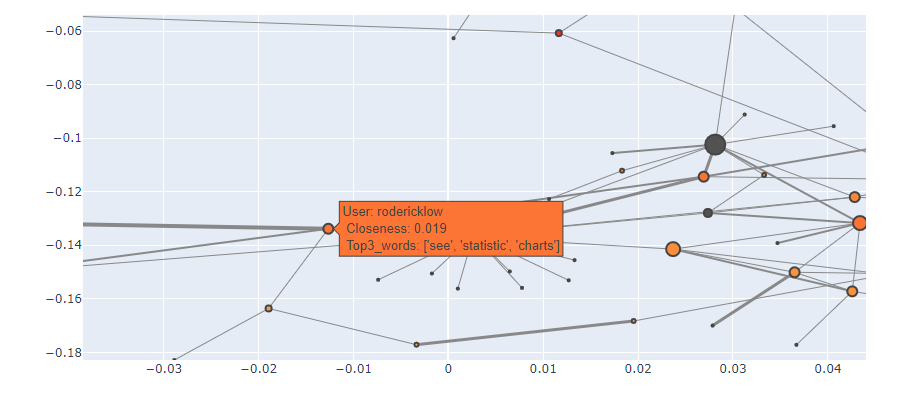

- In the above mention graph, black nodes show that the user has no top words. This means the user has posted URLs or not useful information. 
- If we hover the plus mark on the graph, we get the top 3 words from each user. 
- From the above 3 examples(zoom in mention graph images), it seems that all the connected nodes were discussing or sharing information about the same theme. 
- The users of the taken example happened to discuss some statistics (maybe user statistics or some tools to get statistics of some measure). Words for two nodes are the same except one but the theme seems the same as they are talking about statistics charts or tools.

Source: https://www.datacamp.com/community/tutorials/social-network-analysis-python

# Q(4): Centrality Analysis

# Q4(a): Using PageRank and a 2nd centrality measure of your choosing, calculate the centrality of the nodes on your graph based on each of the measures.

In [45]:
def plotNetworkSizeColor_centrality(graph , centrality_measure):

    if centrality_measure == "betweenness":

      centrality = nx.betweenness_centrality(tweetGraph)  # betweenness centrality 
    else:

      centrality = nx.pagerank(tweetGraph)                # pagerank 


    maxCentr = max(centrality.values())
    minCentr = min(centrality.values())
    
    scatters=[]

    for (node1, node2) in graph.edges():
        x0, y0 = graph.nodes[node1]['pos']
        x1, y1 = graph.nodes[node2]['pos']
        edgeWidth = graph[node1][node2]['numberMentions']
        s = Scatter(
                x=[x0, x1],
                y=[y0, y1],
                hoverinfo='none',
                mode='lines', 
                line=scatter.Line(width=edgeWidth ,color='#888'))
        scatters.append(s)



    for node in graph.nodes():
        nodeCentr = centrality[node]
    
        nodeColor = int(299*(nodeCentr-minCentr)/(maxCentr-minCentr))
        xPos, yPos = graph.nodes[node]['pos']
        s = Scatter(
                x=[xPos], 
                y=[yPos], 
                text="User: %s <br> Closeness: %.3f <br> Top3_words: %s" % (node, nodeCentr, str(userWiseTopWords(tweetTag, user=node))),
                hoverinfo='text',
                mode='markers', 
                marker=dict(
                    color=purd300[nodeColor], 
                    size=nx.degree(graph,node)*2,         
                    line=dict(width=2)))
        scatters.append(s)
    
    layout = Layout(showlegend=False)
    fig = Figure(data=scatters, layout=layout)
    iplot(fig, show_link=False)

In [46]:
pagerank  = nx.pagerank(tweetGraphSpring)
pagerank

{'mizzlizzbeck': 0.00047732696897374703,
 'beckelhimer': 0.00047732696897374703,
 'rustysteelwool': 0.00047732696897374703,
 'devan_': 0.00047732696897374703,
 'sabria': 0.0015790276774827164,
 'jordi_ruizr': 0.0002937101842222521,
 'luismiguelromer': 0.0002937101842222521,
 'alexhereza': 0.0002937101842222521,
 'hector_san': 0.0002937101842222521,
 'peremarti': 0.0002937101842222521,
 'pedropporto': 0.0002937101842222521,
 'champagnemanoir': 0.0002072432001148962,
 'ruth_z': 0.001595992115342871,
 'wahlbuzz': 0.014608001422488472,
 'clippinx': 0.00025571823920257945,
 'roger213tm': 0.0009180072523773345,
 'boxsociety': 0.0003304335411725511,
 'roger123tm': 0.0003304335411725511,
 'el_confeti': 0.0003304335411725511,
 'joelfernandes': 0.0008695592311624123,
 'keithdsouza': 0.00021951390353185384,
 'adamsconsulting': 0.00036475412012587074,
 'featureblend': 0.002589804280151695,
 'reiver': 0.00036475412012587074,
 'beiercai)': 0.00036475412012587074,
 'luchoedu': 0.000697667110675541,
 

In [47]:
betweenness_centrality = nx.betweenness_centrality(tweetGraphSpring, normalized= True)
betweenness_centrality

{'mizzlizzbeck': 0.0,
 'beckelhimer': 0.0,
 'rustysteelwool': 0.0,
 'devan_': 0.0,
 'sabria': 6.84502989224554e-06,
 'jordi_ruizr': 0.0,
 'luismiguelromer': 0.0,
 'alexhereza': 0.0,
 'hector_san': 0.0,
 'peremarti': 0.0,
 'pedropporto': 0.0,
 'champagnemanoir': 0.0,
 'ruth_z': 0.003357459848569273,
 'wahlbuzz': 0.009321561707259975,
 'clippinx': 0.0,
 'roger213tm': 1.369005978449108e-06,
 'boxsociety': 0.0,
 'roger123tm': 0.0,
 'el_confeti': 0.0,
 'joelfernandes': 0.00038811319489032213,
 'keithdsouza': 0.0,
 'adamsconsulting': 2.2816766307485133e-07,
 'featureblend': 0.003738755327144514,
 'reiver': 2.2816766307485133e-07,
 'beiercai)': 2.2816766307485133e-07,
 'luchoedu': 4.5633532614970265e-07,
 'mfunes': 0.0,
 'cabralita': 0.0,
 'firesphere': 0.0,
 'michielveenstra': 0.0,
 'crysthewolf': 0.0,
 'threadless': 0.006016477051733063,
 'lajourno': 0.0,
 'romenesko)': 0.0,
 'writepudding': 0.0,
 'firstpagepro': 0.0,
 'jawar': 9.126706522994052e-06,
 'nextmoon': 0.01307674510614588,
 'stef

## Betweenness centrality mention graph:

In [48]:
configure_plotly_browser_state()
plotNetworkSizeColor_centrality(tweetGraphSpring , centrality_measure = "betweenness")

Output hidden; open in https://colab.research.google.com to view.

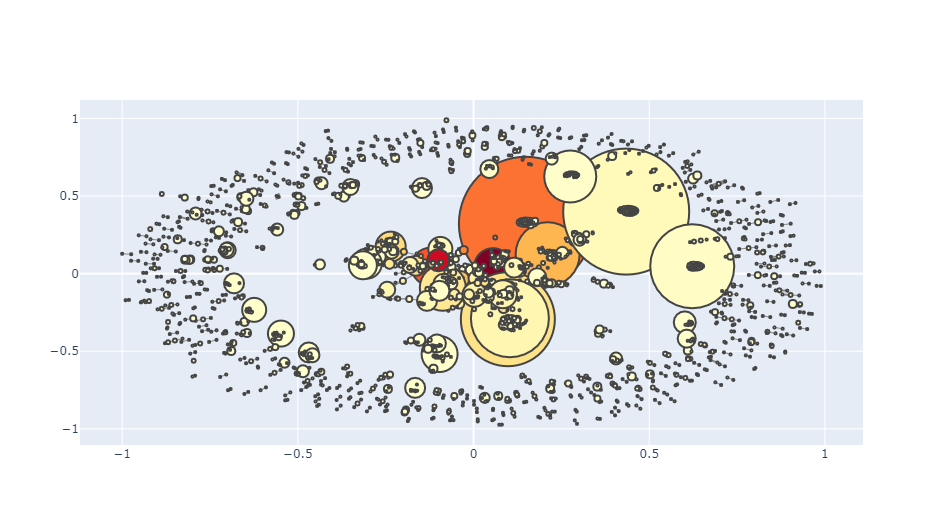

## Pagerank mention graph:

In [49]:
configure_plotly_browser_state()
plotNetworkSizeColor_centrality(tweetGraphSpring, centrality_measure= "pagerank")

Output hidden; open in https://colab.research.google.com to view.

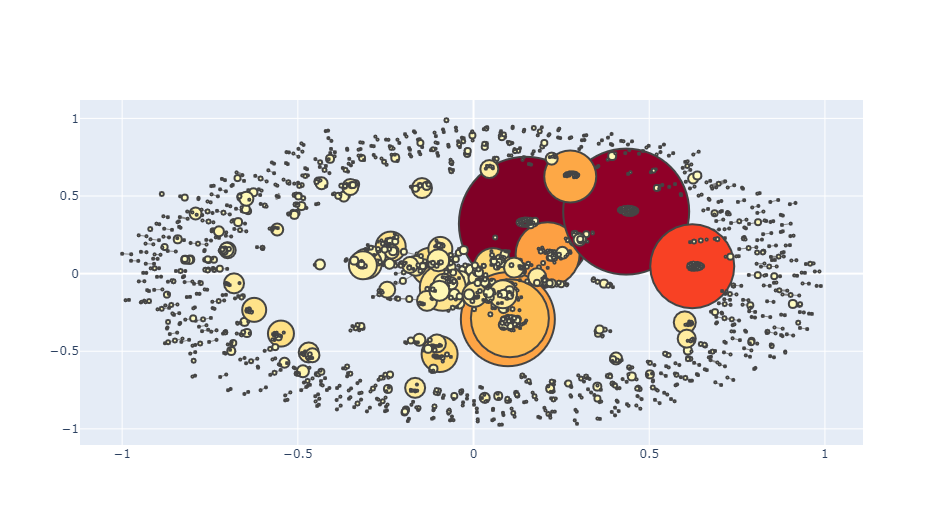

- As we can see that the above two graphs represent betweenness centrality and pagerank centrality. 
- The darker the node the higher it has centrality in both graphs. 

# Q4(b): List the 5 most central nodes for each of the centrality measures 

In [50]:
print("Top 5 most central nodes according to pagerank:",sorted(nx.pagerank(tweetGraphSpring), key=nx.pagerank(tweetGraphSpring).get, reverse=True)[:5])

Top 5 most central nodes according to pagerank: ['wahlbuzz', 'tpoem', 'tpoema', 'threadless', 'twitter']


In [51]:
print("Top 5 most central nodes according to betweenness centrality:",sorted(nx.betweenness_centrality(tweetGraphSpring), key=nx.betweenness_centrality(tweetGraphSpring).get, reverse=True)[:5])

Top 5 most central nodes according to betweenness centrality: ['', 'susuh', 'stefanw', 'nextmoon', 'mashable']


- The results from the top 5 centrality users/nodes are different from each other. 
- We encounter a significant difference between the two results. The reason being Pagerank gives a high rank or centrality score to those users who have been mentioned several times by other users (Indegree) whereas betweenness centrality gives more centrality score to those nodes who are acting as a bridge in information transfer between other nodes. 
- Betweenness centrality is a better measure for twitter data analysis. As twitter is a social media and on this platform to know a key person who spreads more information is more important compared to know a user who has been mentioned several times by other users.
- Betweenness centrality represents a person who controls knowledge flows. High betweenness centrality suggests that other nodes in that network have to pass through that particular node/user to spread information. So high betweenness centrality represents a highly important or influential person in that network. We need to identify a person who can influence other people easily for different types of analysis or business perspective. 
- Pagerank is more useful in ranking website pages, understating citations in research papers, etc.

# Q(5):  Sentiment Analysis

# Q5(a): Using NRCLex, evaluate each tweet and determine the number of words in each dimension of emotion. Construct a chart showing the number of words in each emotion.

In [52]:
# tweet = tweetTag['tweet'][8347]
# text_object = NRCLex(tweet)
# absolute_numbers = text_object.raw_emotion_scores
# list(absolute_numbers)

In [53]:
tweetTag_emotion = tweetTag.copy()

In [54]:
# making a dataframe with all emotions as a column
# Making columns list to add it in the dataframe later
columns = ["anger","anticipation","disgust","fear","joy","negative","positive","sadness","surprise","trust"]
tweetTag_emotion[columns] = 0

for index, tweet_data in tweetTag_emotion.iterrows():
  tweet = tweet_data['tweet']
  text_object = NRCLex(tweet)

  relative_numbers = text_object.affect_frequencies
  absolute_numbers = text_object.raw_emotion_scores

  for i in columns:
    for j in list(absolute_numbers):
      if i==j:
        tweetTag_emotion[i][index]= absolute_numbers[i]

tweetTag_emotion.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



date            user  ... surprise trust
2632  2009-06-11 17:01:45     cancunforos  ...        0     0
4190  2009-06-11 17:05:47    mizzlizzbeck  ...        0     0
7625  2009-06-11 17:10:25       eviatar_s  ...        0     0
8347  2009-06-11 17:10:58        non53n53  ...        0     0
9401  2009-06-11 17:11:48  rustysteelwool  ...        0     0

[5 rows x 15 columns]

In [55]:
# the number of words in each dimension of emotions 

sentiment_counts = tweetTag_emotion[columns].sum(axis=0)
sentiment_counts

anger           194
anticipation    486
disgust          91
fear            293
joy             282
negative        489
positive        695
sadness         289
surprise        197
trust           406
dtype: int64

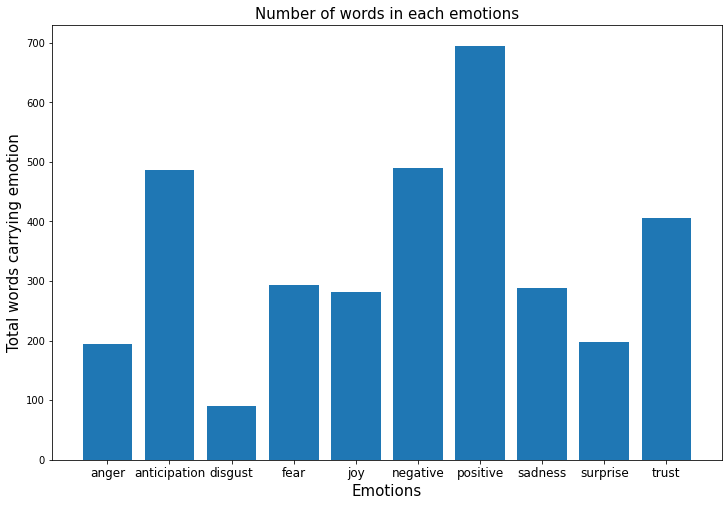

In [56]:
# bar graph for number of words in each emotions

plt.figure(figsize=(12,8))
plt.bar(columns,sentiment_counts)
plt.xlabel("Emotions", size = 15)
plt.xticks(size = 12)
plt.ylabel("Total words carrying emotion", size = 15)
plt.title("Number of words in each emotions", size = 15)
plt.show()

In [57]:
tweetTag_emotion[tweetTag_emotion["positive"]==3]["tweet"].values[1]

'Who Else Wants 75,000 Page Views With Just 10 Mintes Of Work? Grab Your Free Traffic Training Here :http://vitaldollars.com/link/onfringe\n2009-06-12 03:12:57\tmelanie_pizza\tChastity Bono is having a sex change to become a man. You go! http://bit.ly/pIr93\n2009-06-12 03:12:57\tmrscrubby\t@brewskiebutt http://twitpic.com/75hgw - Get it, Brew! That looks like an awesome banana.\n2009-06-12 03:12:57\tshiraishi_unso\tPhoto: sorshi: http://tumblr.com/x8y20pkr7\n2009-06-12 03:12:57\ttonywill07\tHa ha! Monkey in a cute outfit ridding a dog (pic) http://www.modernpooch.com/archives/whiplash1.jpg\n2009-06-12 03:12:58\t_danwaneji\tトリコのインタビューでてるね > Reading 『人喰いの大鷲トリコ』上田文人氏インタビュー - ファミ通.com http://bit.ly/HDyuD\n2009-06-12 03:12:58\tbethlabreche\tFollowing Goodwill\'s masterful marketing -- not afraid to admit I shop the \'will -- it\'s eco friendly too http://tinyurl.com/ox4rbx\n2009-06-12 03:12:58\tcarlosdejesus\tStereo MC\'s – Connected" #TwitterRadio ♫ http://blip.fm/~82rly'

In [58]:
tweetTag_emotion[tweetTag_emotion["positive"]==1]["tweet"].values[2]

"I question the ubiquity of #Twitter but what do you think? http://bit.ly/fW3dj (Mashable). Definitely don't think it's jumped the shark."

In [59]:
tweetTag_emotion[tweetTag_emotion["positive"]==2]["tweet"].values[3]

'RT @pfeifenschneide Murmur Study | Christopher Baker #twitter auf papier #kunst #art #inspiration (via @real12monkey) http://wong.to/1csan'

- Most of the words lie in the positive emotion as we can observe in the above bar graph. 
- The example tweets show that people were talking about some positive things like, in the first example "amazing girl", in the second example "ubiquity of Twitter" and in the third example "Win a copy" like these words show some positive emotions. That's why most of the tweets were having positive sentiment. 

# Q5(b): For each user, determine which fraction of a user’s total identified words are in each emotional affect (i.e., normalize the counts for each user).

In [60]:
# checking the length of unique users
len(tweetTag["user"].unique())

1715

In [61]:
# userwise addition of each emotion 
tweetTag_emotion_userwise = pd.DataFrame(tweetTag_emotion.groupby('user')[columns].sum())
tweetTag_emotion_userwise.shape # checking the shape of dataframe(double checking the unique number of users)

(1715, 10)

In [62]:
# adding total counts of words column in the dataframe
tweetTag_emotion_userwise["total_words"] = tweetTag_emotion_userwise.sum(axis=1)

In [63]:
tweetTag_emotion_userwise.head()

anger  anticipation  disgust  ...  surprise  trust  total_words
user                                           ...                              
02mytwi01            0             0        0  ...         0      0            3
0lli                 0             0        0  ...         0      0            0
1230jackie           0             1        0  ...         0      1            2
12serendipity21      0             0        0  ...         0      1            3
1outside             0             0        0  ...         0      1            3

[5 rows x 11 columns]

In [64]:
tweetTag_emotion_userwise_fraction = tweetTag_emotion_userwise[columns].div(tweetTag_emotion_userwise["total_words"], axis = 0).round(2) # finding fraction of words per user by dividing total count of words
tweetTag_emotion_userwise_fraction["total_words"] = tweetTag_emotion_userwise["total_words"]
tweetTag_emotion_userwise_fraction = tweetTag_emotion_userwise_fraction.replace(np.nan, 0 ) # replacing NaN values as it is coming from zero division
tweetTag_emotion_userwise_fraction.head()

anger  anticipation  disgust  ...  surprise  trust  total_words
user                                           ...                              
02mytwi01          0.0           0.0      0.0  ...       0.0   0.00            3
0lli               0.0           0.0      0.0  ...       0.0   0.00            0
1230jackie         0.0           0.5      0.0  ...       0.0   0.50            2
12serendipity21    0.0           0.0      0.0  ...       0.0   0.33            3
1outside           0.0           0.0      0.0  ...       0.0   0.33            3

[5 rows x 11 columns]

In [65]:
# users with the highest fraction of words in each emotion

tweetTag_emotion_userwise_fraction.idxmax()

anger            dominickerala
anticipation           _nick__
disgust              babyswags
fear                   energia
joy             adognamedpants
negative         anthonytaurus
positive           antharris88
sadness         acappellamedia
surprise              askdzign
trust                   ahzing
total_words           wahlbuzz
dtype: object

- The above users have the highest fraction of words in the given emotions.

# Q5(c): Is there a correlation between any dimension of emotion and one of the centrality measures you evaluated?

In [66]:
 # total number of users 
 tweetTag_emotion["user"].shape

(2950,)

In [67]:
# total number of nodes in betweenness centrality 
len(betweenness_centrality)

2095

In [68]:
# total number of nodes in pagerank centrality 
len(pagerank)

2095

### Maping betweenness and pagerank centrality to the emotion dataframe to find correlation between emotions and centrality

In [69]:
tweetTag_emotion['betweenness_centrality'] = tweetTag_emotion['user'].map(betweenness_centrality)
tweetTag_emotion['pagerank'] = tweetTag_emotion['user'].map(pagerank)

In [70]:
tweetTag_emotion.head()

date            user  ... betweenness_centrality  pagerank
2632  2009-06-11 17:01:45     cancunforos  ...                    NaN       NaN
4190  2009-06-11 17:05:47    mizzlizzbeck  ...               0.000000  0.000477
7625  2009-06-11 17:10:25       eviatar_s  ...               0.000018  0.000340
8347  2009-06-11 17:10:58        non53n53  ...               0.000000  0.000291
9401  2009-06-11 17:11:48  rustysteelwool  ...               0.000000  0.000477

[5 rows x 17 columns]

### There are some of the NaN values as not all users are converted into nodes during finding centrality as they don't have been mentioned by others or they haven't mentioned anyone. Those nodes/users do not carry any useful information or spread information. So those nodes have been removed by the centrality algorithm. 
### Now during mapping these centrality values to the dataframe, it gives some NaN values as these users do not exist in centrality nodes. So I am removing those users from the dataframe. 

In [71]:
tweetTag_emotion = tweetTag_emotion.dropna()
tweetTag_emotion.head()

date            user  ... betweenness_centrality  pagerank
4190  2009-06-11 17:05:47    mizzlizzbeck  ...               0.000000  0.000477
7625  2009-06-11 17:10:25       eviatar_s  ...               0.000018  0.000340
8347  2009-06-11 17:10:58        non53n53  ...               0.000000  0.000291
9401  2009-06-11 17:11:48  rustysteelwool  ...               0.000000  0.000477
9848  2009-06-11 17:12:31          sabria  ...               0.000007  0.001579

[5 rows x 17 columns]

## Calculating correlation matrix 

In [72]:
corr = tweetTag_emotion[["anger","anticipation","disgust","fear","joy","negative","positive","sadness","surprise","trust","betweenness_centrality","pagerank"]].corr() # finding correlation matrix
corr

anger  ...  pagerank
anger                   1.000000  ... -0.033982
anticipation            0.311348  ... -0.048328
disgust                 0.457493  ... -0.006252
fear                    0.369912  ...  0.407881
joy                     0.339994  ...  0.000651
negative                0.645972  ...  0.261800
positive                0.375846  ... -0.012101
sadness                 0.392728  ...  0.436459
surprise                0.370535  ... -0.016094
trust                   0.376858  ... -0.025905
betweenness_centrality -0.044980  ...  0.771305
pagerank               -0.033982  ...  1.000000

[12 rows x 12 columns]

## Correlation chart between "Betweenness centrality" and "Emotions"

In [73]:
corr_target_betweenness_centrality = abs(corr["betweenness_centrality"])
relevant_emotions_betweenness_centrality =pd.DataFrame(corr_target_betweenness_centrality)

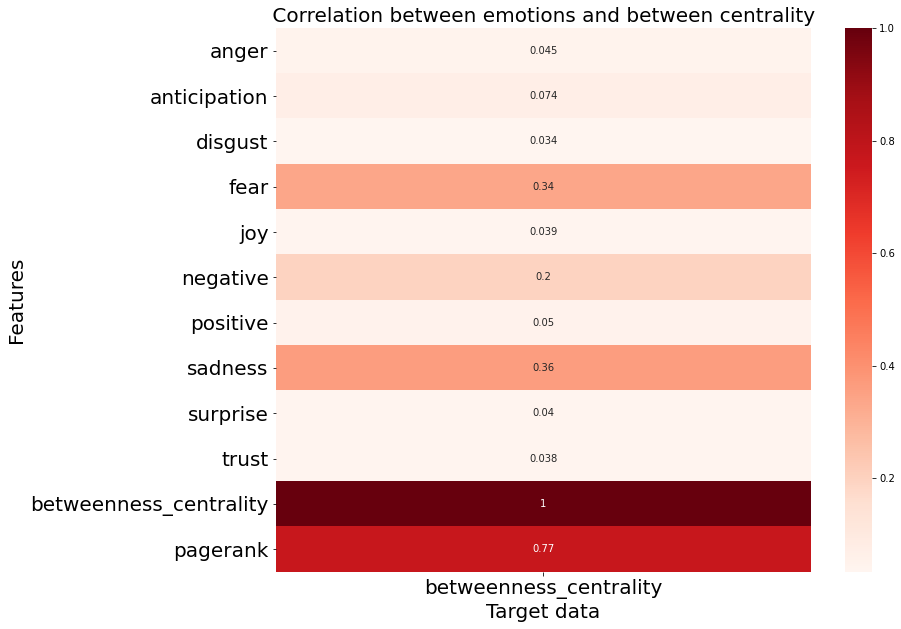

In [74]:
plt.figure(figsize=(12,10))
sns.heatmap(relevant_emotions_betweenness_centrality, annot=True, cmap=plt.cm.Reds)
plt.title(' Correlation between emotions and between centrality ' , size = 20)
plt.xlabel('Target data',  size = 20)
plt.ylabel('Features',  size = 20)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

## Correlation chart between "Pagerank centrality" and "Emotions"

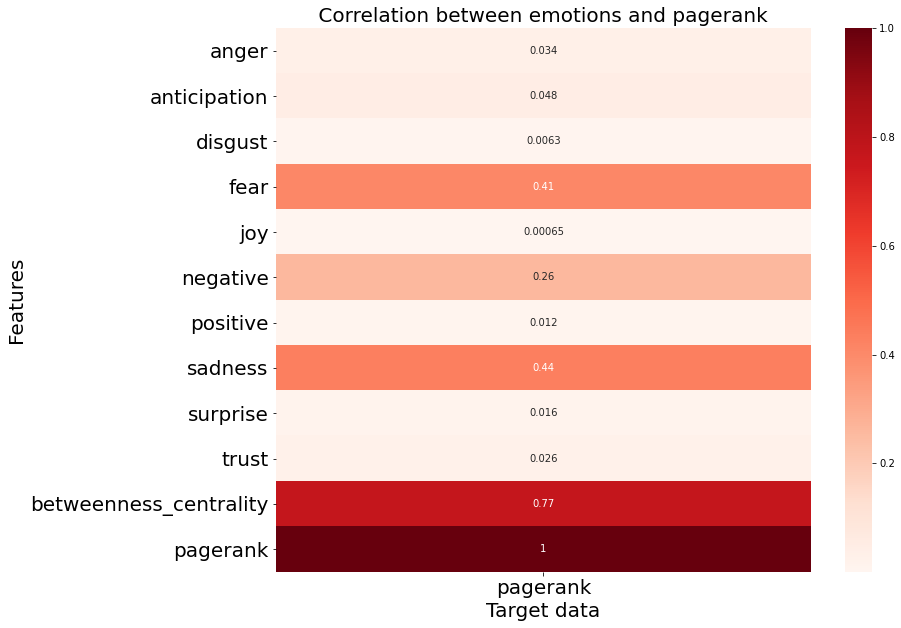

In [75]:
corr_target_pagerank = abs(corr["pagerank"])
relevant_emotions_pagerank =pd.DataFrame(corr_target_pagerank)
plt.figure(figsize=(12,10))
sns.heatmap(relevant_emotions_pagerank, annot=True, cmap=plt.cm.Reds)
plt.title(' Correlation between emotions and pagerank ' , size = 20)
plt.xlabel('Target data',  size = 20)
plt.ylabel('Features',  size = 20)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

In [76]:
# sorting values by betweenness centrality column
tweetTag_emotion.sort_values(by = "betweenness_centrality", ascending= False).head(20)

date      user  ... betweenness_centrality  pagerank
2061365  2009-06-13 15:03:58     susuh  ...               0.013750  0.001602
2857008  2009-06-14 09:20:16     susuh  ...               0.013750  0.001602
843308   2009-06-12 12:20:23     susuh  ...               0.013750  0.001602
2887574  2009-06-14 10:19:17     susuh  ...               0.013750  0.001602
717852   2009-06-12 09:07:11     susuh  ...               0.013750  0.001602
853886   2009-06-12 12:35:17     susuh  ...               0.013750  0.001602
3034347  2009-06-14 14:40:15     susuh  ...               0.013750  0.001602
2079649  2009-06-13 15:27:28   stefanw  ...               0.013189  0.001031
2994786  2009-06-14 13:37:30   stefanw  ...               0.013189  0.001031
910490   2009-06-12 13:44:09   stefanw  ...               0.013189  0.001031
963663   2009-06-12 14:39:53   stefanw  ...               0.013189  0.001031
28973    2009-06-11 17:41:25  nextmoon  ...               0.013077  0.000350
704164   2009-06-12 08:45:07  wahlbuzz  ...               0.009322  0.014608
704247   2009-06-12 08:45:10  wahlbuzz  ...               0.009322  0.014608
1196067  2009-06-12 19:02:03  wahlbuzz  ...               0.009322  0.014608
778068   2009-06-12 10:45:03  wahlbuzz  ...               0.009322  0.014608
1279153  2009-06-12 20:45:10  wahlbuzz  ...               0.009322  0.014608
695429   2009-06-12 08:30:08  wahlbuzz  ...               0.009322  0.014608
1316728  2009-06-12 21:41:40  wahlbuzz  ...               0.009322  0.014608
1319836  2009-06-12 21:45:07  wahlbuzz  ...               0.009322  0.014608

[20 rows x 17 columns]

In [77]:
# sorting values by pagerank centrality column
tweetTag_emotion.sort_values(by = "pagerank", ascending= False).head(20)

date      user  ... betweenness_centrality  pagerank
861433   2009-06-12 12:45:17  wahlbuzz  ...               0.009322  0.014608
861230   2009-06-12 12:45:11  wahlbuzz  ...               0.009322  0.014608
787631   2009-06-12 11:00:04  wahlbuzz  ...               0.009322  0.014608
787736   2009-06-12 11:00:09  wahlbuzz  ...               0.009322  0.014608
808226   2009-06-12 11:30:07  wahlbuzz  ...               0.009322  0.014608
818544   2009-06-12 11:45:05  wahlbuzz  ...               0.009322  0.014608
828595   2009-06-12 12:00:03  wahlbuzz  ...               0.009322  0.014608
839021   2009-06-12 12:15:03  wahlbuzz  ...               0.009322  0.014608
839140   2009-06-12 12:15:06  wahlbuzz  ...               0.009322  0.014608
839179   2009-06-12 12:15:07  wahlbuzz  ...               0.009322  0.014608
861112   2009-06-12 12:45:08  wahlbuzz  ...               0.009322  0.014608
861182   2009-06-12 12:45:10  wahlbuzz  ...               0.009322  0.014608
861310   2009-06-12 12:45:13  wahlbuzz  ...               0.009322  0.014608
778139   2009-06-12 10:45:05  wahlbuzz  ...               0.009322  0.014608
885601   2009-06-12 13:15:04  wahlbuzz  ...               0.009322  0.014608
123347   2009-06-11 20:15:01  wahlbuzz  ...               0.009322  0.014608
111079   2009-06-11 19:51:05  wahlbuzz  ...               0.009322  0.014608
984043   2009-06-12 15:00:08  wahlbuzz  ...               0.009322  0.014608
106176   2009-06-11 19:45:08  wahlbuzz  ...               0.009322  0.014608
1013696  2009-06-12 15:30:10  wahlbuzz  ...               0.009322  0.014608

[20 rows x 17 columns]

In [78]:
tweetTag_emotion[tweetTag_emotion["user"]=="wahlbuzz"]["tweet"].values[0]

'Hi @clippinx - die #twitterwahl hat Deinen letzten Tweet erfasst -&gt; http://snurl.com/twitterwahl'

In [79]:
len(tweetTag_emotion[tweetTag_emotion["user"]=="wahlbuzz"]["tweet"].values)

66

- From both correlation charts, we can observe that there is some correlation between both centrality and "fear" and "sadness" emotions.
- As we probe into the tweets, we can find that a user named "wahlbuzz" had made 66 tweets and all tweets were the same. 
- This user had made tweets in the German language and it is as shown in the above code. 
- The tweet has the word "die" and that triggers the emotion of fear and sadness and this we can also observe in the above top centrality tweets-emotion dataframe. 
- Now the translation of the tweet is "the #twitterwahl recorded your last tweet", so the word "die" in English is "the". 
- The given NRC Lexicon can evaluate emotions from English words. Due to this, all 66 tweets came under fear and sadness emotions. 
- The user had mentioned so many other users in each tweet, which makes him an influential person in the network. And that's why he has highest PageRank centrality and he has secured his score in the top 10 betweenness centrality scores. 
- Due to all these reasons, we have found a correlation between fear and sadness emotions with centrality measures.( This does not represent the exact relation between the centrality and emotions as NRC lexicon is unable to evaluate German language emotions)

# As suggested in the post on piazza regarding workload reduction, I am going to skip 6th question of the assignment. I have completed the user study involving an interactive sequential recommender system experiment. 



#  "I completed the user study on Dec 06 at 5:00am using username: harsh.panchal@mail.utoronto.ca"

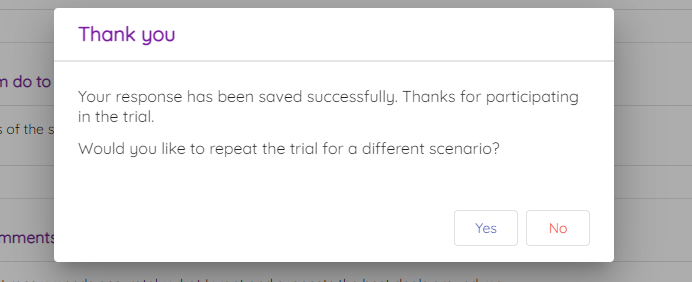